# Figure 6. a) and b) analyses

This notebook contains the compound selection and essential gene-chemical interaction prediction analysis used to generate the results in Fig. 6. The statistics in Fig. 6 a) and random permutation results from Fig. 6 b) are reported.

In [1]:
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import NearestNeighbors
from scipy.stats import hypergeom
from statsmodels.stats.multitest import fdrcorrection

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib_venn import venn2

## Part 1. Compound selection

First, import the nonessential gene minipool data (derived from [Piotrowski 2017](https://www.nature.com/articles/nchembio.2436/)), which specifies compounds and corresponding sensitive genes. This file contains compounds with two or more sensitive genes.

In [2]:
with Path("../data/chemical-genetics/minipool-faroutlier-interactions.json").open("r") as f:
    minipool = json.load(f)  # {compound1: [gene1, gene2, ...], ...}

Import BIONIC features from integrating a PPI, co-expression and GI network. These are the same features used in the Fig. 2 and 3 analyses.

In [3]:
features = pd.read_csv("../data/methods/yeast_BIONIC_features.csv", index_col=0)
bionic_genes = set(features.index)

Define a function to split the genes for a given compound into train and test sets for 5 trials.

In [4]:
def split_genes(genes: list, test_size: float = 0.1, n_trials: int = 5):

    genes = np.array(genes)

    # compute validation split size
    n_val = math.ceil(len(genes) * test_size)
    n_splits = math.ceil(len(genes) / n_val)

    # ensure there are not more folds than genes
    n_trials = min(len(genes), n_trials)

    # get random idxs corresponding to genes
    rand_idxs = np.arange(len(genes))
    np.random.shuffle(rand_idxs)

    # split `rand_idxs` into test splits
    test_splits = np.array_split(rand_idxs, n_splits)

    # get training splits and map `test_splits` from indices to genes
    train_splits = []
    test_splits_ = []
    for test_split in test_splits:
        train_splits.append(
            genes[np.array([i for i in np.arange(len(genes)) if i not in test_split])]
        )
        test_splits_.append(genes[test_split])

    # pair train splits with corresponding test splits
    splits = list(zip(train_splits, test_splits_))

    # return the first `n_trials` train/test splits
    return splits[:n_trials]

Define a function to compute a feature vector to represent the given compound based on the genes it sensitizes. This will be used both in the compound selection process, and to generate the essential gene-chemical interaction predictions.

In [5]:
def compute_compound_features(features):

    # compute cosine centroid by row normalizing, computing mean and rescaling,
    # see here: https://stats.stackexchange.com/a/412747/180465
    features_normed = Normalizer().fit_transform(features.values)
    features_normed_sum = np.sum(features_normed, axis=0)
    normed_centroid = Normalizer().fit_transform(features_normed_sum.reshape((1, -1)))
    vector_sizes = np.linalg.norm(features.values, axis=1)
    average_vector_size = np.mean(vector_sizes)
    centroid = average_vector_size * normed_centroid  # represents the compound feature vector

    return centroid

Define a function to generate predictions for minipool senstive genes in the test set given the BIONIC features and training set sensitive genes.

In [6]:
def get_nearest_neighbors(features, training_genes):

    # subset `features` to `training_genes`
    features_sub = features.loc[training_genes]

    # get feature vector representing the compound
    centroid = compute_compound_features(features_sub)

    # create ranked list of compound-gene nearest neighbor hits
    nn = NearestNeighbors(n_neighbors=20, metric="cosine")
    nn.fit(features.values)
    dists, neighbors = nn.kneighbors(centroid, return_distance=True)
    dists, neighbors = (
        dists[0],
        neighbors[0],
    )

    neighbors = features.index[neighbors]  # predicted sensitive genes

    return neighbors

Define an ordered Fisher's exact test to assess the quality of BIONIC sensitive gene predictions.

In [7]:
def ordered_fisher(features, neighbors, targets):

    targets_set = set(targets)

    lowest_pval = 1

    # iterate over increasing sized subsets of ranked list (`neighbors`) and track lowest p-val 
    for idx in range(len(neighbors)):

        neighbors_subset = neighbors[: idx + 1]

        [k, M, n, N] = [
            len(set(neighbors_subset).intersection(targets_set)),
            len(features.index),
            len(targets_set),
            len(neighbors_subset),
        ]
        prob = hypergeom.pmf(k, M, n, N)
        if prob < lowest_pval:
            lowest_pval = prob

    return lowest_pval

Iterate over compounds and score BIONIC predictions for each.

In [8]:
results = {}
for compound, genes in minipool.items():

    # filter minipool data to only include genes in `emb`
    genes = list(bionic_genes.intersection(set(genes)))
    if len(genes) < 2:
        continue

    splits = split_genes(genes)
    pvals = []
    for train, test in splits:
        neighbors = get_nearest_neighbors(features, train)

        pval = ordered_fisher(features, neighbors, test)
        pvals.append(pval)

    avg_pval = sum(pvals) / len(pvals)  # compute average p-val over train/test splits
    results[compound] = avg_pval

results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1])}  # sort by p-val
results = pd.DataFrame(list(results.items()), columns=["Compound", "p-value"])

We then take the top 50 scoring compounds from the `results` DataFrame. These are the selected compounds that BIONIC will make essential gene-compound interaction predictions for. Due to the random train/test splitting, the compounds in `results` may differ very slightly from the compounds selected in the manuscript. We import the selected compounds from the manuscript to ensure consistency for the remaining analysis.

In [9]:
selected_compounds = list(results.iloc[:50]["Compound"])

# import manuscript selected compounts
selected_compounds = list(
    pd.read_csv("../data/chemical-genetics/selected-compounds.txt", sep="\n", header=None
)[0])
print(selected_compounds)

['NP329', 'NPD7279', 'NPE498', 'NPD5998', 'NPE792', 'Camptothecin', 'NPE736', 'NPD5154', 'NPD6889', 'NPD4907', 'NPD7518', 'NPD3076', 'Micafungin', 'NPD7050', 'Hedamycin', 'NPE348', 'NP344', 'NPD6617', 'NPD7880', 'NPD401', 'NPE888', 'NPD1395', 'NPD4027', 'NPE546', 'NPE752', 'NPD6849', 'NPD5175', 'NPD228', 'NPE576', 'NPD6009', 'NPD435', 'NPD5403', 'NPD5421', 'NPD5731', 'NPD8203', 'NPE927', 'NPE787', 'Acivicin', 'NPD2399', 'NPD7813', 'NPD2735', 'NPE282', 'NPD3934', 'NPD5017', 'NPD6517', 'NPD5676', 'NPD1918', 'NPD1498', 'NPD6956', 'NPD824']


## Part 2. Essential gene-chemical interaction predictions

Next we generate a set of essential gene-chemical interaction predictions for the 50 compounds in `selected_compounds`. We also test bioprocess enrichment for the predicted sensitive essential genes.

In [10]:
# import genes we have TS alleles for (i.e. essential genes we can experimentally screen)
ts_genes = list(
    pd.read_csv("../data/chemical-genetics/TS-genes.txt", sep="\n", header=None)[0]
)

# create a subset of `features` consisting of genes in `ts_genes`
common_genes = np.intersect1d(list(bionic_genes), ts_genes)
features_ts = features.loc[common_genes]

# import ORF to gene name mapper file
with Path("../data/chemical-genetics/yeast-orf2name-mapper.json").open("r") as f:
    orf_mapper = json.load(f)

Make essential gene-compound interaction predictions for the compounds selected in part 1 (`selected_compounds`).

In [11]:
# first define a function since we'll use this again to produce fig. b)
def make_predictions(features, common_genes):
    features_ts = features.loc[common_genes]
    predictions = {}
    for compound in selected_compounds:

        # get genes sensitive to compounds from minipool data
        training_genes = minipool[compound]

        # subset `features` to `training_genes`
        training_genes = np.intersect1d(training_genes, list(bionic_genes))
        features_train = features.loc[training_genes]

        # compute feature vector for `compound`
        centroid = compute_compound_features(features_train)

        # compute 20 nearest essential gene neighbors to `centroid`
        nn = NearestNeighbors(n_neighbors=20, metric="cosine")
        nn.fit(features_ts.values)
        _, neighbors = nn.kneighbors(centroid, return_distance=True)

        # `neighbors` are indices, so get corresponding genes
        neighbors = list(features_ts.index[neighbors.flatten()])

        predictions[compound] = neighbors
    
    return predictions

predictions = make_predictions(features, common_genes)
# `predictions` contains the essential gene-chemical interactions for each compound
# for example, show the predicted genes for NP329 and map genes from ORFs to gene names
print([orf_mapper[orf] if orf in orf_mapper else orf for orf in predictions["NP329"]])

['KRE5', 'KRE9', 'KEG1', 'BIG1', 'ROT1', 'TRS130', 'WBP1', 'TPT1', 'PKC1', 'PGA1', 'GPI17', 'GPI13', 'GAB1', 'GPI18', 'SMP3', 'GPI10', 'KAR2', 'GAA1', 'GPI11', 'RHO1']


## Part 3. Comparison with experimental screens

Finally, we compare the predicted interactions in `predictions` with the experimentally screened sensitive essential genes. We compute the bioprocess overlap between the enriched bioprocesses of the BIONIC predictions and the annotated bioprocesses of the experimental results. We also compute the significance of the BIONIC predictions using an ordered Fisher's exact test.

In [12]:
# import experimental screen results
with Path("../data/chemical-genetics/TS-compound-screen-results.json").open("r") as f:
    screen_results = json.load(f)

# import Costanzo bioprocess standard
with Path("../data/standards/Costanzo-bioprocess.json").open("r") as f:
    bioprocesses = json.load(f)

# reduce the bioprocess standard to only include TS genes that are also in `features`
new_bioprocesses = {}
for bioprocess, genes in bioprocesses.items():
    intersection_genes = np.intersect1d(genes, common_genes)
    if len(intersection_genes) > 0:
        new_bioprocesses[bioprocess] = intersection_genes
bioprocesses = new_bioprocesses

# get bioprocess annotations for each compound
compound_annotations = {}
for compound, genes in screen_results.items():
    annotated_biops = set()
    for bioprocess, bioprocess_genes in bioprocesses.items():
        bioprocess_genes_set = set(bioprocess_genes)
        for gene in genes:
            if gene in bioprocess_genes_set:
                annotated_biops.add(bioprocess)
    compound_annotations[compound] = list(annotated_biops)

# show annotations for "NP329"
print(compound_annotations["NP329"])

['Nuclear-cytoplasmic transport', 'Cell polarity & morphogenesis', 'Vesicle traffic', 'tRNA wobble modification', 'Glycosylation, protein folding/targeting, cell wall biosynthesis']


Define a function to determine biological processes enrichment.

In [13]:
def get_significant_bioprocesses(standard: dict, common_genes: list, predicted_genes: list):
    biop_pvals = []
    negative_biops = []

    # compute enrichment p-values for each bioprocess in `standard`
    for biop, genes in standard.items():
        [k, M, n, N] = [
            len(set(genes).intersection(set(predicted_genes))),
            len(common_genes),
            len(genes),
            len(predicted_genes),
        ]
        cdf = hypergeom.cdf(k, M, n, N)

        # track negative tailed (depleted) results to remove later
        if cdf < 0.5:
            negative_biops.append(biop)
        biop_pvals.append(hypergeom.pmf(k, M, n, N))

    # perform FDR correction
    significance, corrected_biop_pvals = fdrcorrection(biop_pvals)
    sig_biops = np.array(list(standard.keys()))[significance]
    sig_pvals = corrected_biop_pvals[significance]

    # remove significant bioprocesses that are depleted
    sig_biops_new = []
    sig_pvals_new = []
    for biop, pval in zip(sig_biops, sig_pvals):
        if biop in negative_biops:
            continue
        sig_biops_new.append(biop)
        sig_pvals_new.append(pval)
    sig_biops = sig_biops_new
    sig_pvals = sig_pvals_new

    res = {biop: pval for biop, pval in zip(sig_biops, sig_pvals)}
    res = {
        k: v for k, v in sorted(res.items(), key=lambda item: item[1])
    }  # sort from smallest p-value to largest
    return res

We compute the bioprocesses enriched for the BIONIC sensitive essential gene predictions.

In [14]:
predicted_annotations = {}
for compound, genes in predictions.items():
    enriched_bioprocesses = get_significant_bioprocesses(
        bioprocesses, common_genes, genes
    )
    predicted_annotations[compound] = enriched_bioprocesses

# show enriched bioprocesses for BIONIC NP329 predictions
predicted_annotations["NP329"]

{'Glycosylation, protein folding/targeting, cell wall biosynthesis': 2.405340205949834e-20}

We then compute the significance of the BIONIC sensitive essential gene predictions for each compound using an ordered Fisher's exact test.

In [15]:
compound_pvals = {}
for compound, predicted_genes in predictions.items():
    true_genes = screen_results[compound]

    pval = ordered_fisher(features_ts, predicted_genes, true_genes)
    compound_pvals[compound] = pval

# perform FDR correction on p-values
_, corrected_pvals = fdrcorrection(list(compound_pvals.values()))
compound_pvals = {compound: pval for compound, pval in zip(compound_pvals.keys(), corrected_pvals)}

# show NP329 p-value
compound_pvals["NP329"]

6.083498096647935e-08

### Fig. a)

Compute the overlap between screened and predicted sensitive essential genes, number of significantly predicted compounds, and biological process overlap.

Total genes: 156, Correct predictions: 35
Significantly enriched compounds: 13
Total bioprocesses: 62, Correct bioprocesses: 27


<Figure size 432x288 with 0 Axes>

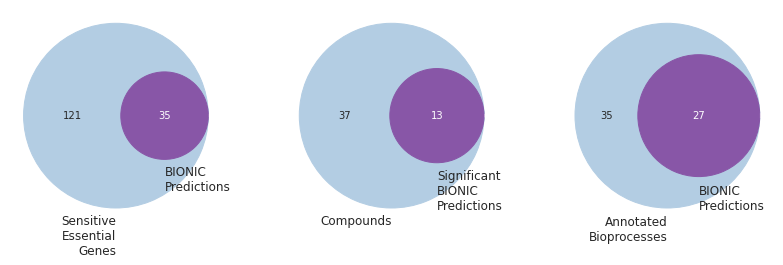

In [16]:
# compute total sensitive essentials and correctly predicted essentials
total_sensitive_genes = sum([len(sensitive_genes) for sensitive_genes in screen_results.values()])
correct_sensitive_genes = 0
for compound, predicted_genes in predictions.items():
    true_genes = screen_results[compound]
    correct_sensitive_genes += len(np.intersect1d(predicted_genes, true_genes))
print(f"Total genes: {total_sensitive_genes}, Correct predictions: {correct_sensitive_genes}")

# compute number of significantly predicted compounds
significant_compounds = sum([1 if pval < 0.05 else 0 for pval in compound_pvals.values()])
print(f"Significantly enriched compounds: {significant_compounds}")

# compute the bioprocess overlap
total_bioprocesses = sum([len(bioprocesses) for bioprocesses in compound_annotations.values()])
correct_bioprocesses = 0
for compound, predicted_annot in predicted_annotations.items():
    predicted_annot = list(predicted_annot.keys())
    true_annot = compound_annotations[compound]
    correct_bioprocesses += len(np.intersect1d(predicted_annot, true_annot))
print(f"Total bioprocesses: {total_bioprocesses}, Correct bioprocesses: {correct_bioprocesses}")


# plot venn diagrams
sns.set({"figure.facecolor": "white"})
plt.clf()
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, ax in enumerate(axes):
    if i == 0:
        AnotB = total_sensitive_genes - correct_sensitive_genes
        BnotA = 0
        AandB = correct_sensitive_genes
        v = venn2(
            subsets=(AnotB, BnotA, AandB),
            set_labels=("Sensitive\nEssential\nGenes", "BIONIC\nPredictions"),
            ax=ax
        )

    if i == 1:
        AnotB = len(selected_compounds) - significant_compounds
        BnotA = 0
        AandB = significant_compounds
        v = venn2(
            subsets=(AnotB, BnotA, AandB),
            set_labels=("Compounds", "Significant\nBIONIC\nPredictions"),
            ax=ax
        )

    if i == 2:
        AnotB = total_bioprocesses - correct_bioprocesses
        BnotA = 0
        AandB = correct_bioprocesses
        v = venn2(
            subsets=(AnotB, BnotA, AandB),
            set_labels=("Annotated\nBioprocesses", "BIONIC\nPredictions"),
            ax=ax
        )
    
    v.get_patch_by_id("10").set_color("#b3cde3")
    v.get_patch_by_id("10").set_alpha(1.0)
    v.get_patch_by_id("11").set_color("#8856a7")
    v.get_patch_by_id("11").set_alpha(1.0)
    v.get_label_by_id("11").set_color("white")
    v.get_label_by_id("01").set_text("")

plt.show()

### Fig. b)

Generate new sensitive essential gene and bioprocess predictions for randomly permuted BIONIC gene features. Compare the resulting correct prediction ratios between the randomly permuted features and the original BIONIC features. **NOTE** this will take a few minutes to run.

In [17]:
# compute correct predictions ratios for unpermuted BIONIC predictions
gene_pred_ratio = correct_sensitive_genes / total_sensitive_genes
bioprocess_pred_ratio = correct_bioprocesses / total_bioprocesses

# next iterate over random permutations of the BIONIC features and make predictions
rand_gene_ratios = []
rand_bioprocess_ratios = []

# ran for 1000 iterations in manuscript, reduced here to 100 to reduce computation time
for _ in range(100):

    # randomly permute gene labels
    rand_features = features.copy()
    rand_features.index = rand_features.index[np.random.permutation(len(rand_features))]

    # compute correct sensitive gene prediction ratio
    rand_predictions = make_predictions(rand_features, common_genes)
    rand_correct_sensitive_genes = 0
    for compound, predicted_genes in rand_predictions.items():
        true_genes = screen_results[compound]
        rand_correct_sensitive_genes += len(np.intersect1d(predicted_genes, true_genes))
    rand_gene_ratios.append(rand_correct_sensitive_genes / total_sensitive_genes)

    # compute enriched bioprocesses and correct bioprocess prediction ratio
    rand_correct_bioprocesses = 0
    for compound, predicted_genes in rand_predictions.items():
        enriched_bioprocesses = get_significant_bioprocesses(
            bioprocesses, common_genes, predicted_genes
        )
        predicted_annot = list(enriched_bioprocesses.keys())
        true_annot = compound_annotations[compound]
        rand_correct_bioprocesses += len(np.intersect1d(predicted_annot, true_annot))
    rand_bioprocess_ratios.append(rand_correct_bioprocesses / total_bioprocesses)

Plot the resulting distributions. **NOTE** that due to the randomness of the permutation procedure, and because we only took 100 samples instead of 1000, these plots may look slightly different than what is reported in the manuscript.

<Figure size 432x288 with 0 Axes>

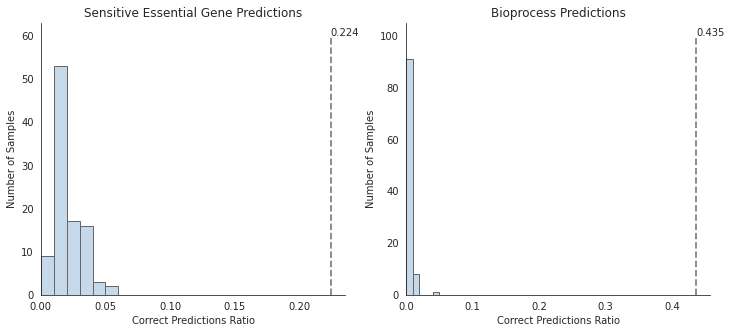

In [18]:
plt.clf()
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, ax in enumerate(axes):
    if i == 0:
        x = rand_gene_ratios
        line = gene_pred_ratio
        ax.set_title("Sensitive Essential Gene Predictions")
    if i == 1:
        x = rand_bioprocess_ratios
        line = bioprocess_pred_ratio
        ax.set_title("Bioprocess Predictions")

    sns.histplot(x=x, ax=ax, color="#b3cde3", edgecolor="#666666", binwidth=0.01)
    ax.set_ylabel("Number of Samples")
    ax.set_xlabel("Correct Predictions Ratio")
    max_y = max(ax.get_yticks())
    ax.plot([line, line], [0, max_y], c=(0, 0, 0, 0.5), ls="--", lw=1.75)
    ax.text(line, max_y, f"{line:.3f}")
    ax.set_xlim(0)

sns.despine()
plt.show()